In [1]:
import pandas as pd
import numpy as np
import sys
import os


pd.set_option('display.max_columns', None)

In [45]:
product_details = pd.read_csv(r"C:\Users\HomePC\Downloads\Perishable Goods Prediction\perishable-goods\perishable_dataset\data\product_details.csv")
store_info = pd.read_csv(r"C:\Users\HomePC\Downloads\Perishable Goods Prediction\perishable-goods\perishable_dataset\data\store_info.csv")
supplier_info = pd.read_csv(r"C:\Users\HomePC\Downloads\Perishable Goods Prediction\perishable-goods\perishable_dataset\data\supplier_info.csv")
weather_data = pd.read_csv(r"C:\Users\HomePC\Downloads\Perishable Goods Prediction\perishable-goods\perishable_dataset\data\weather_data.csv")
weekly_sales = pd.read_csv(r"C:\Users\HomePC\Downloads\Perishable Goods Prediction\perishable-goods\perishable_dataset\data\weekly_sales.csv")

In [46]:
store_info

,Store_ID,Region,Store_Size,Cold_Storage_Capacity
0,500,London,12000,3788
1,501,Midlands,5000,1086
2,502,North East,4000,998
3,503,Midlands,5000,1243
4,504,London,10000,3330
5,505,North West,3000,920
6,506,South West,4000,1262
7,507,North West,4000,1056
8,508,Midlands,5000,1023
9,509,London,10000,2762


In [47]:
print(weekly_sales.head())

  Week_Number  Product_ID  Store_ID  Units_Sold  Marketing_Spend  \
0    2024-W01        1000       500        4853           670.37   
1    2024-W01        1001       500        4274          1089.62   
2    2024-W01        1002       500        4215          1004.99   
3    2024-W01        1003       500        5768           859.45   
4    2024-W01        1004       500        3403           576.70   

   Discount_Percent  Wastage_Units  Price  
0                 0            718   2.46  
1                 0            641   1.27  
2                10            632   2.74  
3                20            853   1.82  
4                 0            503   3.46  


In [48]:
# Merge all datasets
merged_data = weekly_sales.merge(product_details, on='Product_ID', how='left') \
    .merge(store_info, on='Store_ID', how='left') \
    .merge(weather_data, on=['Week_Number', 'Region'], how='left') \
    .merge(supplier_info, on='Supplier_ID', how='left')

merged_data.dropna(inplace=True)

In [ ]:
import pandas as pd
from datetime import datetime, timedelta

def week_to_date(week_str):
    """Convert week string like '2024-W01' to actual date"""
    year, week = week_str.split('-W')
    year = int(year)    
    week = int(week)
    
    jan1 = datetime(year, 1, 1)
    
    days_to_monday = (7 - jan1.weekday()) % 7
    if jan1.weekday() == 0:
        days_to_monday = 0
    
    first_monday = jan1 + timedelta(days=days_to_monday)
    
    target_date = first_monday + timedelta(weeks=week-1)
    
    return target_date

merged_data['Date'] = merged_data['Week_Number'].apply(week_to_date)


### Feature Selection with Mutual Info Regression

In [50]:
merged_data['Date'] = pd.to_datetime(merged_data['Date'], errors='coerce')
merged_data['Year'] = pd.to_numeric(merged_data['Date'].dt.year)
merged_data['Month'] = pd.to_numeric(merged_data['Date'].dt.month)
merged_data['Day'] = pd.to_numeric(merged_data['Date'].dt.day)

In [51]:
merged_data['Wastage_Rate_trend'] = (
    merged_data.groupby(['Product_ID', 'Store_ID'])['Wastage_Units']
    .rolling(4)
    .mean()
    .reset_index(level=[0,1], drop=True)
)

In [52]:
merged_data.drop(columns=['Date', 'Week_Number', 'Wastage_Units'], axis = 1, inplace = True)

                  Feature  Mutual Information
18     Wastage_Rate_trend            0.404030
4        Product_Category            0.333812
3            Product_Name            0.329120
5         Shelf_Life_Days            0.246495
2                   Price            0.157878
6                  Region            0.140519
8   Cold_Storage_Capacity            0.137601
7              Store_Size            0.133999
10               Rainfall            0.080891
9         Avg_Temperature            0.075368
14        Supply_Capacity            0.072762
12          Supplier_Name            0.072456
0         Marketing_Spend            0.031086
16                  Month            0.019678
17                    Day            0.010352
1        Discount_Percent            0.009597
11           Holiday_Flag            0.005634
13         Lead_Time_Days            0.004833
15                   Year            0.000000


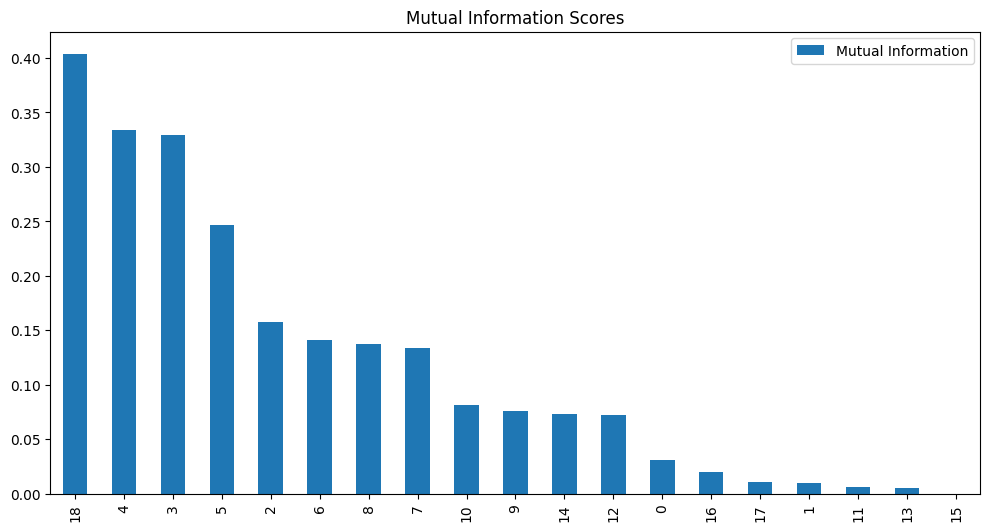

In [54]:
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt

mutual_data = merged_data.copy()

for col in mutual_data.select_dtypes(include=['object']).columns:
    mutual_data[col] = pd.Categorical(mutual_data[col]).codes

target = mutual_data['Units_Sold']
features = mutual_data.drop(columns=['Units_Sold', 'Product_ID', 'Store_ID', 'Supplier_ID'])
features = features.fillna(features.median())
target = target.fillna(target.median)
mi_scores = mutual_info_regression(features, target)
mi_scores = mi_scores = pd.DataFrame({
    'Feature': features.columns,
    'Mutual Information': mi_scores
})
mi_scores = mi_scores.sort_values(by='Mutual Information', ascending=False)
print(mi_scores)

mi_scores.plot(kind='bar', figsize=(12, 6))
plt.title('Mutual Information Scores')
plt.show()

In [55]:
training_features = mi_scores.head(15)['Feature'].tolist()

In [56]:
training_features

['Wastage_Rate_trend',
 'Product_Category',
 'Product_Name',
 'Shelf_Life_Days',
 'Price',
 'Region',
 'Cold_Storage_Capacity',
 'Store_Size',
 'Rainfall',
 'Avg_Temperature',
 'Supply_Capacity',
 'Supplier_Name',
 'Marketing_Spend',
 'Month',
 'Day']

### Feature Encoding

In [57]:
print(merged_data[training_features].select_dtypes(include=['object']).nunique())

main_data = merged_data[training_features].copy()
merged_data[training_features].select_dtypes(include=['object'])

Product_Category     4
Product_Name        48
Region               6
Supplier_Name       10
dtype: int64


,Product_Category,Product_Name,Region,Supplier_Name
0,Bakery,Whole Wheat Bread 800g,London,PremiumGoods Wholesale
1,Bakery,White Sandwich Loaf,London,TrustedSource Provisions
2,Bakery,Croissant 4-pack,London,LocalHarvest Distributors
3,Bakery,Blueberry Muffins 6-pack,London,BestQuality Foods Ltd.
4,Bakery,Chocolate Chip Cookies,London,SwiftDelivery Foods UK
...,...,...,...,...
37435,Beverages,English Breakfast Tea 80bags,South West,GreenValley Suppliers
37436,Beverages,Sparkling Water 1L,South West,FreshFoods UK Ltd.
37437,Beverages,Lemonade 2L,South West,GreenValley Suppliers
37438,Beverages,Protein Shake 4-pack,South West,TrustedSource Provisions


In [68]:
merged_data

,Product_ID,Store_ID,Units_Sold,Marketing_Spend,Discount_Percent,Price,Product_Name,Product_Category,Shelf_Life_Days,Supplier_ID,Region,Store_Size,Cold_Storage_Capacity,Avg_Temperature,Rainfall,Holiday_Flag,Supplier_Name,Lead_Time_Days,Supply_Capacity,Year,Month,Day,Wastage_Rate_trend
0,1000,500,4853,670.37,0,2.46,Whole Wheat Bread 800g,Bakery,4,4,London,12000,3788,9.9,23.0,1,PremiumGoods Wholesale,3,48776,2024,1,1,NaN
1,1001,500,4274,1089.62,0,1.27,White Sandwich Loaf,Bakery,2,8,London,12000,3788,9.9,23.0,1,TrustedSource Provisions,3,46959,2024,1,1,NaN
2,1002,500,4215,1004.99,10,2.74,Croissant 4-pack,Bakery,2,5,London,12000,3788,9.9,23.0,1,LocalHarvest Distributors,2,11306,2024,1,1,NaN
3,1003,500,5768,859.45,20,1.82,Blueberry Muffins 6-pack,Bakery,4,10,London,12000,3788,9.9,23.0,1,BestQuality Foods Ltd.,2,53748,2024,1,1,NaN
4,1004,500,3403,576.70,0,3.46,Chocolate Chip Cookies,Bakery,4,7,London,12000,3788,9.9,23.0,1,SwiftDelivery Foods UK,2,59474,2024,1,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37435,1043,514,895,488.97,15,1.62,English Breakfast Tea 80bags,Beverages,246,9,South West,3000,1001,8.7,16.2,1,GreenValley Suppliers,3,54320,2024,12,23,33.5
37436,1044,514,1558,657.76,10,5.05,Sparkling Water 1L,Beverages,186,1,South West,3000,1001,8.7,16.2,1,FreshFoods UK Ltd.,1,68047,2024,12,23,28.0
37437,1045,514,993,442.56,0,5.72,Lemonade 2L,Beverages,356,9,South West,3000,1001,8.7,16.2,1,GreenValley Suppliers,3,54320,2024,12,23,31.5
37438,1046,514,2168,1502.52,25,3.82,Protein Shake 4-pack,Beverages,158,8,South West,3000,1001,8.7,16.2,1,TrustedSource Provisions,3,46959,2024,12,23,30.5


In [ ]:
norminal_columns = ['Product_Category', 'Region']
high_cardinality_columns = ['Product_Name', 'Supplier_Name']

for col in norminal_columns:
    dummies = pd.get_dummies(main_data[col], prefix=col)
    dummies = dummies.astype(int)
    main_data = pd.concat([main_data, dummies], axis=1)
    main_data.drop(columns=[col], inplace=True)

In [59]:
for col in high_cardinality_columns:
    target_mean = main_data.groupby(col)['Price'].mean()
    main_data[col] = main_data[col].map(target_mean)

In [60]:
main_data.dtypes

Wastage_Rate_trend            float64
Product_Name                  float64
Shelf_Life_Days                 int64
Price                         float64
Cold_Storage_Capacity           int64
Store_Size                      int64
Rainfall                      float64
Avg_Temperature               float64
Supply_Capacity                 int64
Supplier_Name                 float64
Marketing_Spend               float64
Month                           int32
Day                             int32
Product_Category_Bakery         int64
Product_Category_Beverages      int64
Product_Category_Dairy          int64
Product_Category_Meat           int64
Region_London                   int64
Region_Midlands                 int64
Region_North East               int64
Region_North West               int64
Region_South East               int64
Region_South West               int64
dtype: object

In [64]:
main_data['Units_Sold'] = merged_data['Units_Sold'].values

In [65]:
main_data

,Wastage_Rate_trend,Product_Name,Shelf_Life_Days,Price,Cold_Storage_Capacity,Store_Size,Rainfall,Avg_Temperature,Supply_Capacity,Supplier_Name,Marketing_Spend,Month,Day,Product_Category_Bakery,Product_Category_Beverages,Product_Category_Dairy,Product_Category_Meat,Region_London,Region_Midlands,Region_North East,Region_North West,Region_South East,Region_South West,Units_Sold
0,NaN,2.439103,4,2.46,3788,12000,23.0,9.9,48776,3.631560,670.37,1,1,1,0,0,0,1,0,0,0,0,0,4853
1,NaN,2.326103,2,1.27,3788,12000,23.0,9.9,46959,3.323019,1089.62,1,1,1,0,0,0,1,0,0,0,0,0,4274
2,NaN,2.388256,2,2.74,3788,12000,23.0,9.9,11306,3.776321,1004.99,1,1,1,0,0,0,1,0,0,0,0,0,4215
3,NaN,2.486821,4,1.82,3788,12000,23.0,9.9,53748,4.848548,859.45,1,1,1,0,0,0,1,0,0,0,0,0,5768
4,NaN,2.420526,4,3.46,3788,12000,23.0,9.9,59474,5.008087,576.70,1,1,1,0,0,0,1,0,0,0,0,0,3403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37435,33.5,4.127949,246,1.62,1001,3000,16.2,8.7,54320,5.950755,488.97,12,23,0,1,0,0,0,0,0,0,0,1,895
37436,28.0,4.121154,186,5.05,1001,3000,16.2,8.7,68047,3.475910,657.76,12,23,0,1,0,0,0,0,0,0,0,1,1558
37437,31.5,4.200910,356,5.72,1001,3000,16.2,8.7,54320,5.950755,442.56,12,23,0,1,0,0,0,0,0,0,0,1,993
37438,30.5,4.151782,158,3.82,1001,3000,16.2,8.7,46959,3.323019,1502.52,12,23,0,1,0,0,0,0,0,0,0,1,2168


## Building Base Model

In [71]:
def train_linear_model(data):
    from sklearn.model_selection import train_test_split
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
    from sklearn.impute import SimpleImputer
    import numpy as np

    X = data.drop(columns=['Units_Sold'])
    y = data['Units_Sold']
    
    imputer = SimpleImputer(strategy='median')
    X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)
    
    y_imputed = y.fillna(y.median())

    X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=0.3, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"RMSE: {rmse}")
    print(f"R^2: {r2}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")

    return model

In [72]:
model = train_linear_model(main_data)

RMSE: 669.9027244264014
R^2: 0.6624179700144199
MAE: 467.5295074380431
MAPE: 0.33660093560027027


In [66]:
def train_rf_model(data):
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

    X = data.drop(columns=['Units_Sold'])
    y = data['Units_Sold']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    import pickle 
    with open('rf_model.pkl', 'wb') as file:
        pickle.dump(model, file)
    
    import json
    with open('schema.json', 'w') as f:
        json.dump({"features": X.columns.tolist()}, f)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)

    print(f"RMSE: {rmse}")
    print(f"R^2: {r2}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")

    return model

In [67]:
model = train_rf_model(main_data)

RMSE: 535.3468240377535
R^2: 0.7844111512136993
MAE: 364.50880787037033
MAPE: 0.25059419846023967
